# Goal
Determine if yearly fantasy footbal stats can be used to predict next year's stats <br>
focus on year long stats to ignore huge week-to-week variation <br>
focus on wide recievers to simply any differences between position groups<br>
get stats from PFF.com

### Import data from source

filter data to just take WRs <br>
also filter to take the top 50% of targets - this is about 30, which is about 2 per game.  This is a reasonable metric to filter out the least targeted WRs <br>
Choose list of fields that could be relevant - this is largley a judgement call

In [2]:
import pandas as pd
import numpy as np

years = [2018,2019,2020,2021,2022,2023,2024]
columns = ['player', 'player_id', 'position', 'team_name', 'player_game_count',
       'avg_depth_of_target', 'slot_rate', 'targeted_qb_rating', 'targets', 'touchdowns', 'wide_rate',
       'yards_after_catch_per_reception', 'yards_per_reception', 'yprr']
new_columns = ['fpts', 'fpts_game', 'targets_game', 'touchdowns_game']

# import one csv file for each year
dataframes = {}
for year in years:
       location = 'FF\Yearly\\' + str(year) + '.csv'
       df = pd.read_csv(location)
       df = df[df['position'] == 'WR']
       df = df[df['targets'] > df['targets'].quantile(0.5)]
       
       # calcualte fantasy points
       df['fpts'] = df['receptions'] * 0.5 + df['yards'] * 0.1 + df['touchdowns'] * 6
       # calculate per game metrics
       df['fpts_game'] = df['fpts'] / df['player_game_count']
       df['targets_game'] = df['targets'] / df['player_game_count']
       df['touchdowns_game'] = df['touchdowns'] / df['player_game_count']
       df_columns = columns + new_columns
       df = df[df_columns]
       df['year'] = year
       dataframes[year] = df


# select columns that contain non string values
data_columns = ['avg_depth_of_target', 'slot_rate', 'targeted_qb_rating', 'targets', 'touchdowns', 'wide_rate',
       'yards_after_catch_per_reception', 'yards_per_reception', 'yprr', 'fpts', 'fpts_game', 'targets_game', 'touchdowns_game']

#combine all csvs into one
wr_data = pd.concat(list(dataframes.values()))
wr_data_names = pd.DataFrame(wr_data['player'].unique()).copy()
wr_data_names.columns = ['player']

#aggregate data by creating a list of all values for each stat that occured before the given year
wr_df_list = []
for year in years:
       if year == 2018: continue
       wr_data_split = wr_data_names.copy()
       for column in data_columns:
              df = wr_data[wr_data['year'] < year].groupby('player')[column].apply(list).reset_index()
              wr_data_split = pd.merge(wr_data_split, df, 'inner', 'player')
       wr_data_split['year'] = year
       wr_df_list.append(wr_data_split)

#store raw values here
wr_data_true = pd.concat(wr_df_list).reset_index(drop=True)
wr_data_true = pd.merge(wr_data_true, wr_data[['player', 'year', 'fpts_game']], 'left', ['player', 'year'])
wr_data_true.rename(columns={'fpts_game_x': 'fpts_game', 'fpts_game_y': 'fpts_game_actual'}, inplace=True)
wr_data_true = wr_data_true.dropna(subset=['fpts_game_actual']).reset_index(drop=True)

#create new dataframe that stores the std, mean and slope for each list of values
wr_data_stats = wr_data_true.copy()
for column in data_columns:
       std = np.array(np.std(pd.DataFrame(wr_data_stats[column].tolist()),axis=1))
       mean = np.array(np.mean(pd.DataFrame(wr_data_stats[column].tolist()),axis=1))
       slope = np.array((np.max(pd.DataFrame(wr_data_stats[column].tolist()),axis=1) 
                         - np.min(pd.DataFrame(wr_data_stats[column].tolist()),axis=1)) 
                         / pd.DataFrame(wr_data_stats[column].tolist()).notna().sum(axis=1))

       wr_data_stats[column] = np.column_stack((std, mean, slope)).tolist()
# wr_data_stats = wr_data_stats[wr_data_stats['year'] > 2019]

# wr_data_stats
# wr_data_stats.to_csv('output.csv', index=False)


### First analysis

#### Inital Results

start with most likely categorie - fpts_game <br>
see if the 3 descriptive stats about fpts_game can describe the actual result <br>
include players that only have 1 data point - results in 418 samples
<br><br>
results <br>
params = ['fpts_game_std', 'fpts_game_mean', 'fpts_game_slope'] <br>
R score  0.3835332807297631 <br>
Slope [-1.50362489  0.8159471   1.95048244] <br>
Intercept 1.33 

In [34]:
#create function to use for repeated linear regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore
import matplotlib.pyplot as plt

def lr_predict (df,attributes,target,rand,chart=False,print_out=True, error=[]):
    columns = attributes + error
    X = df[columns].copy()
    # X = X.apply(zscore)
    y = df[target].copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rand)

    lr = LinearRegression()
    lr.fit(X_train[attributes], y_train)
    r_score = lr.score(X_test[attributes],y_test)
    if print_out: print('R score ',r_score)

    if chart == True:
        y_1 = lr.predict(X_test[attributes])
        plt.scatter(y_1,y_test)
        x = y = np.arange(min(y),max(y))
        plt.plot(x, y)
        if error != []:
            plt.errorbar(y_1,y_test,yerr=X_test[error])
    
    slope = lr.coef_
    intercept = lr.intercept_
    if print_out: print('Slope', slope)
    if print_out: print('Intercept', intercept)
    return r_score, slope, intercept, lr

# lr_predict(wr_pred_long,predidctive_long_itr,30)

493
R score  0.3243042178726844
Slope [-1.70625715  0.79914297  1.83184511]
Intercept 1.7624693421684805


(0.3243042178726844,
 array([-1.70625715,  0.79914297,  1.83184511]),
 1.7624693421684805,
 LinearRegression())

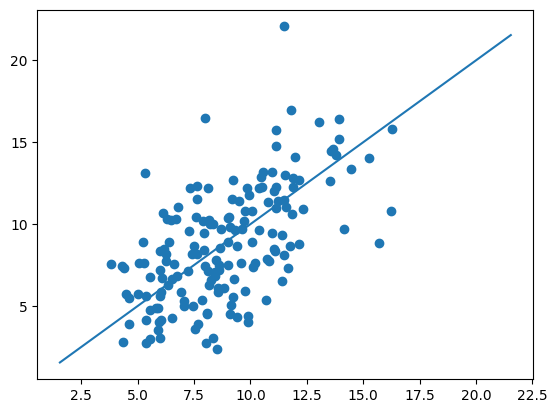

In [42]:
def stat_split (column,input):
    df = input.copy()
    df[column + '_std'] = [x[0] for x in df[column]]
    df[column + '_mean'] = [x[1] for x in df[column]]
    df[column + '_slope'] = [x[2] for x in df[column]]
    df.drop(column,inplace=True,axis=1)
    # df = df[df[column + '_std'] != 0]
    return df

columns = ['player','fpts_game','fpts_game_actual']


wr = stat_split('fpts_game',wr_data_stats[columns])
print(len(wr))

lr_predict(wr,['fpts_game_std', 'fpts_game_mean', 'fpts_game_slope'], 'fpts_game_actual', 30, True)


#### Next Trials 
(none more successful, yearly values very close): <br>
compound factor: fpts_game_mean + fpts_game_slope <br>
compound factor: fpts_game_mean + (fpts_game_slope * fpts_game_std) <br>
factors: targets (broken intto mean, slope, std) <br>
compound factor: earned_fpts <br>
factors: fpts_game_mean, fpts_game_slope, earned_fpts <br> 
factors: use list of yearly values for fpts, not fpts stats
<br><br>

In [ ]:
#fpts combound factors
wr['mean_add_slope'] = wr['fpts_game_mean'] + wr['fpts_game_slope']# * wr['fpts_game_std']

slope, intercept = lr_predict(wr,['fpts_game_mean', 'fpts_game_slope'], 'fpts_game_actual', 30)

wr['predicted'] = wr['fpts_game_mean'] * slope[0] + wr['fpts_game_slope'] * slope[1] + intercept
wr['high'] = wr['predicted'] + wr['fpts_game_std']
wr['low'] = wr['predicted'] - wr['fpts_game_std']
print(len(wr))
print(len(wr[(wr['high'] >= wr['fpts_game_actual']) & (wr['low'] <= wr['fpts_game_actual'])]))

R score  0.34779720630438926
Slope [0.78899116 0.12260949]
Intercept 9.086668426356276
312
123


In [157]:
#earned points and targets
earned_fpts = wr_data['fpts'].sum() / wr_data['targets'].sum()
earned_fpts

columns = ['player','fpts_game','targets_game','fpts_game_actual']

wr = stat_split('fpts_game',wr_data_stats[columns])
wr = stat_split('targets_game', wr)
wr['earned_fpts'] = wr['targets_game_mean'] * earned_fpts

lr_predict(wr,['fpts_game_mean', 'fpts_game_slope', 'earned_fpts'], 'fpts_game_actual', 30, False, False)


(0.3489327116426275,
 array([ 1.17548434,  0.36732656, -0.51187415]),
 2.223773481338701)

R score  0.3635881173530251
Slope [ 0.64958392  0.11257137 -0.07306294 -0.00375638  0.0428161  -0.10554625]
Intercept 2.4147397122194745


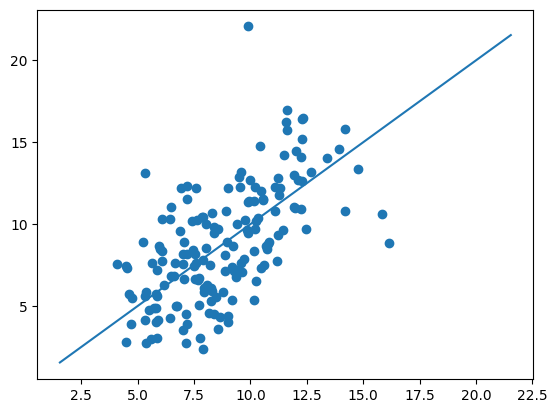

In [211]:
#try true data - start with fantasy points
#create function to split data
def year_split(column, input):
    df = input.copy()
    column_names = []
    for year in range(6):
        year = (year + 1)
        year_neg = year * -1
        column_name = column + str(year_neg)
        df[column_name] = [x[year_neg] if len(x) >= year else 0 for x in df[column]]
        column_names.append(column_name)
    return df, column_names

columns = ['player','fpts_game','fpts_game_actual']
wr_true, factor_columns = year_split('fpts_game', wr_data_true[columns])


r_score, slope, intercept, lr = lr_predict(wr_true,factor_columns, 'fpts_game_actual', 30, True, True)

#### Decide between stats and yearly
The R_score for the stat based and yearly based methods are very close when using the same random seed (30) <br>
run multiple trials to get an average to decide best factors <br>
Result: Stats wins (r = 0.42) over Yearly (r = 0.38)

In [216]:
yearly_rscore = []
stats_rscore = []
for seed in range(100):
    r_score, _, _, _ = lr_predict(wr_true,factor_columns, 'fpts_game_actual', seed, False, False)  
    yearly_rscore.append(r_score)
    r_score, _, _, _ = lr_predict(wr,['fpts_game_std', 'fpts_game_mean', 'fpts_game_slope'], 'fpts_game_actual', seed, False, False)
    stats_rscore.append(r_score)

print('yearly', str(np.mean(yearly_rscore)))
print('stats', str(np.mean(stats_rscore)))

yearly 0.3879388949054279
stats 0.42789079643378153


### Explain Error
based off of the factors found in inital look (fpts_mean, fpts_slope, fpts_std) try to find explaination for error <br>

#### Regression on other factors
first step is to create a measurement of error and to perform linear regression on remaining factors to check for correlation
no factors created an r score better than 0.03 <br>
before this create an average of error based on multiple regression runs with different seeds

In [220]:
#recreate regression for use here
data_columns = ['avg_depth_of_target', 'slot_rate', 'targeted_qb_rating', 'targets', 'touchdowns', 'wide_rate',
       'yards_after_catch_per_reception', 'yards_per_reception', 'yprr', 'fpts_game', 'targets_game', 'touchdowns_game']
key_data = ['fpts_game_actual']
columns = data_columns + key_data
wr = stat_split('fpts_game',wr_data_stats[columns])
#calculate average error over repeated samples

error_columns = []
for seed in range(25):
       r_score, slope, intercept, lr = lr_predict(wr,['fpts_game_std', 'fpts_game_mean', 'fpts_game_slope'], key_data[0], seed, False, False)
       #apply to wr list and find difference from actual
       wr['predicted'] = wr['fpts_game_std'] * slope[0] + wr['fpts_game_mean'] * slope[1] + wr['fpts_game_slope'] * slope[2] + intercept
       error_name = 'error'+str(seed)
       error_columns.append(error_name)
       wr[error_name] = wr['predicted'] - wr['fpts_game_actual']

wr['error'] = np.mean(wr[error_columns],axis=1)
wr.drop(error_columns, inplace=True, axis=1)


In [221]:
#determine if any of the other factors can explain the error
#for each data column find the r_score of the regresion for the error
factor_list = ['avg_depth_of_target', 'slot_rate', 'targeted_qb_rating', 
               'targets', 'touchdowns', 'wide_rate',
               'yards_after_catch_per_reception', 'yards_per_reception', 'yprr', 
               'targets_game', 'touchdowns_game']
key_data = ['fpts_game_actual']
for factor in factor_list:
    wr = stat_split(factor, wr)
    factor_columns = [factor+'_std', factor+'_mean', factor+'_slope']
    r_score, slope, intercept, lr = lr_predict(wr,factor_columns, 'error', 30, False, False)
    print(factor, round(r_score,3))

avg_depth_of_target -0.02
slot_rate -0.03
targeted_qb_rating -0.013
targets 0.006
touchdowns -0.001
wide_rate -0.03
yards_after_catch_per_reception -0.007
yards_per_reception -0.026
yprr -0.055
targets_game 0.012
touchdowns_game 0.008


#### Find other answers

493
246
1.7040707636674568


(array([137., 129.,  97.,  70.,  33.,  15.,   7.,   4.,   0.,   1.]),
 array([1.33808568e-03, 1.07497052e+00, 2.14860296e+00, 3.22223540e+00,
        4.29586783e+00, 5.36950027e+00, 6.44313271e+00, 7.51676514e+00,
        8.59039758e+00, 9.66403002e+00, 1.07376625e+01]),
 <BarContainer object of 10 artists>)

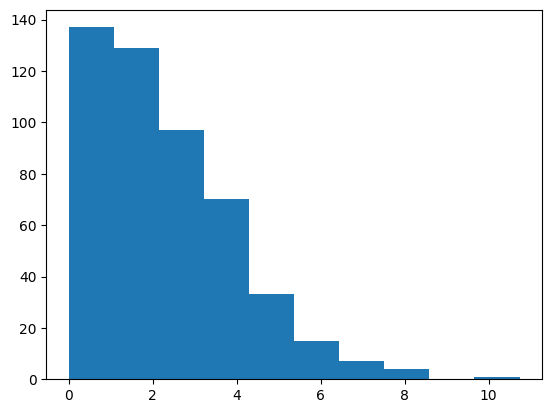

In [51]:
#recreate regression for use here with simplified column list
data_columns = ['fpts_game']
key_data = ['fpts_game_actual']
columns = data_columns + key_data
wr = stat_split('fpts_game',wr_data_stats[columns])
#calculate average error over repeated samples

error_columns = []
predicted_columns = []
r_scores = []
for seed in range(25):
       r_score, slope, intercept, lr = lr_predict(wr,['fpts_game_std', 'fpts_game_mean', 'fpts_game_slope'], key_data[0], seed, False, False)
       r_scores.append(r_score)
       #apply to wr list and find difference from actual
       wr['predicted'] = wr['fpts_game_std'] * slope[0] + wr['fpts_game_mean'] * slope[1] + wr['fpts_game_slope'] * slope[2] + intercept
       error_name = 'error'+str(seed)
       error_columns.append(error_name)
       predicted_name = 'predicted'+str(seed)
       predicted_columns.append(predicted_name)
       wr[error_name] = wr['predicted'] - wr['fpts_game_actual']
       wr[predicted_name] = wr['predicted']

wr['predicted'] = np.mean(wr[predicted_columns], axis=1)
wr.drop(predicted_columns, inplace=True, axis=1)
wr['error'] = np.mean(wr[error_columns], axis=1)
wr.drop(error_columns, inplace=True, axis=1)
wr = wr[['fpts_game_mean', 'fpts_game_std','fpts_game_slope','fpts_game_actual','predicted','error']]
wr['abs_error'] = np.absolute(wr['error'])
print(len(wr))
print(len(wr[wr['abs_error'] <= 2]))
print(wr['abs_error'].std())
plt.hist(wr['abs_error'])

##### Absolute Error
Check if error is related to magnitude of fantasy points, check the same for absolute value of error <br>
check if other factors are more closely related to absolute error than regular error none more than r=0.05<br>

In [242]:
#determine if any of the other factors can explain the error
#for each data column find the r_score of the regresion for the error
factor_list = ['avg_depth_of_target', 'slot_rate', 'targeted_qb_rating', 
               'targets', 'touchdowns', 'wide_rate',
               'yards_after_catch_per_reception', 'yards_per_reception', 'yprr', 
               'targets_game', 'touchdowns_game']
key_data = ['fpts_game_actual']
for factor in factor_list:
    wr_temp = stat_split(factor, wr_data_stats)
    factor_columns = [factor+'_std', factor+'_mean', factor+'_slope']
    for sub_factor in factor_columns:
        wr[sub_factor] = wr_temp[sub_factor]
    r_score, slope, intercept, lr = lr_predict(wr,factor_columns, 'abs_error', 30, False, False)
    print(factor, round(r_score,3))

avg_depth_of_target -0.008
slot_rate -0.048
targeted_qb_rating -0.025
targets -0.018
touchdowns -0.002
wide_rate -0.047
yards_after_catch_per_reception -0.03
yards_per_reception 0.006
yprr 0.015
targets_game 0.011
touchdowns_game -0.019


##### Evaluate Situation Changes
measure tumult, new team, new WR on team <br>
next: new coach, new QB

###### New Team
CONCLUSION: new team penalty of -2 will be included in calculations

In [374]:
#determine if they have a new team
#will also determine for all other wrs on that team if the have a new teammate
wr_tumult = wr.copy()
wr_tumult = pd.merge(wr_tumult, wr_data_stats[['player', 'year']], 'left', left_index=True, right_index=True)
wr_tumult = pd.merge(wr_tumult, wr_data[['player', 'year', 'team_name']], 'left', left_on=['player', 'year'], right_on=['player', 'year'])
wr_tumult['last_year'] = wr_tumult['year'] - 1
wr_tumult = pd.merge(wr_tumult, wr_data[['player', 'year', 'team_name']], 'left', left_on=['player', 'last_year'], right_on=['player', 'year'])
wr_tumult.rename(columns={'year_x': 'year', 'team_name_x': 'team_name', 'team_name_y': 'last_team'}, inplace=True)
wr_tumult.drop('year_y', inplace=True, axis=1)
wr_tumult['same_team'] = wr_tumult['team_name'] == wr_tumult['last_team']


new team quartiles: [-0.58, 1.72, 3.54]
same team quartiles: [-2.24, -0.35, 1.4]
mean quartile diff:  1.9566666666666668


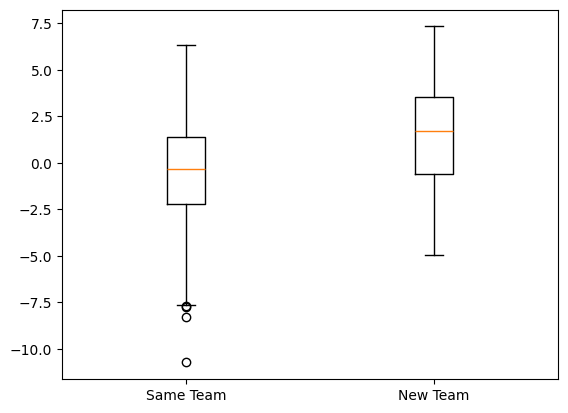

In [362]:
#plot each wr if they have a new team
plt.boxplot([wr_tumult[wr_tumult['same_team'] == True]['error'], wr_tumult[wr_tumult['same_team'] == False]['error']], tick_labels=['Same Team', 'New Team'])
new_team_quarts = []
same_team_quarts = []
for quart in [0.25, 0.5, 0.75]:
    new_team_quarts.append(round(wr_tumult[wr_tumult['same_team'] == False]['error'].quantile(quart),2))
    same_team_quarts.append(round(wr_tumult[wr_tumult['same_team'] == True]['error'].quantile(quart),2))
quartile_diff = [new_team_quarts[0]-same_team_quarts[0],new_team_quarts[1]-same_team_quarts[1],new_team_quarts[2]-same_team_quarts[2]]
print('new team quartiles:', str(new_team_quarts))
print('same team quartiles:', str(same_team_quarts))
print('mean quartile diff: ', str(np.mean(quartile_diff)))

there is clear difference between players going to a new team: all quartiles are ~ +2 more error <br>
This indicates that players that go to a new team are overestimated by 2 points/game

In [375]:
#find the teams that had a new WR and the best average points/game that they added
#this should be a representation of wether a team added a good new WR or just some guy
team_new_wr = wr_tumult.loc[wr_tumult['same_team'] == False,['fpts_game_mean','team_name','year']].groupby(['team_name','year']).max()

wr_tumult['new_wr'] = [team_new_wr.loc[(row[1]['team_name'],int(row[1]['year'])),'fpts_game_mean'] 
 if (row[1]['team_name'], int(row[1]['year'])) in team_new_wr.index
 else 0
 for row in wr_tumult[['team_name','year']].iterrows()]


no good wr added;  [-2.11, -0.05, 1.82]
good wr added:  [-1.43, 0.76, 3.09]
mean quartile differences:  0.92


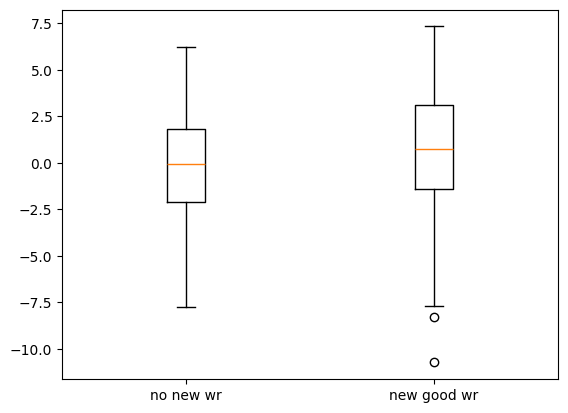

In [364]:
#10 has highest difference while keeping a large sample size (0.92, 108)
good_wr_line = 10

#find cutoff that makes the biggest difference
for cutoff in range(1,int(max(wr_tumult['new_wr']))):
    no_wr_quarts = []
    new_wr_quarts = []
    for quart in [0.25, 0.5, 0.75]:
        no_wr_quarts.append(round(wr_tumult[wr_tumult['new_wr'] <= cutoff]['error'].quantile(quart),2))
        new_wr_quarts.append(round(wr_tumult[wr_tumult['new_wr'] > cutoff]['error'].quantile(quart),2))
    quartile_diff = [new_wr_quarts[0]-no_wr_quarts[0],new_wr_quarts[1]-no_wr_quarts[1],new_wr_quarts[2]-no_wr_quarts[2]]
    if cutoff == good_wr_line:
        print('no good wr added; ', str(no_wr_quarts))
        print('good wr added: ', str(new_wr_quarts))
        print('mean quartile differences: ', str(round(np.mean(quartile_diff),2)))



plt.boxplot([wr_tumult[wr_tumult['new_wr'] <= good_wr_line]['error'], wr_tumult[wr_tumult['new_wr'] > good_wr_line]['error']], tick_labels=['no new wr', 'new good wr'])
plt.show()

there is discernable difference between players that get a new good teammate and others: average quartile is ~ +1 higher error <br>
This indicates that players that get a good new teammate are overestimated by about 1 point per/game
<br><br>
bring both of these ideas together into main calculation

In [371]:
#include a 2 point pentaly for being on a new team
#calcualte current state
mean_sq_err = (wr_tumult['error']**2).mean()
print('MSE Base', str(round(mean_sq_err,3)))
#calculate r_score over multiple samples
r_scores = []
for seed in range(25):
    r_score, slope, intercept, lr = lr_predict(wr_tumult,['predicted'], 'fpts_game_actual', seed, False, False)
    r_scores.append(r_score)
print('r score base: ', str(round(np.mean(r_scores),3)))


#calcualte new state
wr_tumult['ajd_prediction'] = wr_tumult['predicted'] + (1 - wr_tumult['same_team'].astype(int)) * -2
wr_tumult['adj_error'] = wr_tumult['ajd_prediction'] - wr_tumult['fpts_game_actual']
mean_sq_err = (wr_tumult['adj_error']**2).mean()
print('MSE adjusted', str(round(mean_sq_err,3)))
#calculate r_score over multiple samples
r_scores = []
for seed in range(25):
    r_score, slope, intercept, lr = lr_predict(wr_tumult,['ajd_prediction'], 'fpts_game_actual', seed, False, False)
    r_scores.append(r_score)
print('r score adjusted: ', str(round(np.mean(r_scores),3)))

MSE Base 8.176
r score base:  0.406
MSE adjusted 7.81
r score adjusted:  0.443


In [373]:
#calcualte new state
good_wr_line = 10
wr_tumult['ajd_prediction'] = wr_tumult['ajd_prediction'] + (wr_tumult['new_wr'] > good_wr_line).astype(int) * -1
wr_tumult['adj_error'] = wr_tumult['ajd_prediction'] - wr_tumult['fpts_game_actual']
mean_sq_err = (wr_tumult['adj_error']**2).mean()
print('MSE adjusted', str(round(mean_sq_err,3)))
#calculate r_score over multiple samples
r_scores = []
for seed in range(25):
    r_score, slope, intercept, lr = lr_predict(wr_tumult,['ajd_prediction'], 'fpts_game_actual', seed, False, False)
    r_scores.append(r_score)
print('r score adjusted: ', str(round(np.mean(r_scores),3)))

MSE adjusted 8.221
r score adjusted:  0.434


RESULTS with just new team penalty: <br>
MSE Base 8.176<br>
r score base:  0.406<br>
MSE adjusted 7.81<br>
r score adjusted:  0.443<br>
<br><br>
RESULTS with new team penalty new teammate penalty: <br>
MSE adjusted 8.221<br>
r score adjusted:  0.434<br>

CONCLUSION: <br>
new team penalty of -2 will be included in calculations

Also tested: <br>
new factor: value of wr lost from team - had no afffect <br>
tested: new_wr, wr_lost and wr_added_better as a linear regression input - no affect

###### New coach

### Predict change in next year pts
Predict change with absolute value since percentages will be inneffective with small value or 0 <br>
start analysis with fantasy points scored in previous years

In [105]:
#create function to split data
def year_split(column, input):
    df = input.copy()
    column_names = []
    for year in range(6):
        year = (year + 1)
        year_neg = year * -1
        column_name = column + str(year_neg)
        df[column_name] = [x[year_neg] if len(x) >= year else 0 for x in df[column]]
        column_names.append(column_name)
    return df, column_names

columns = ['player','fpts_game','fpts_game_actual']
wr_true, factor_columns = year_split('fpts_game', wr_data_true[columns])


wr_true['fpts_diff'] = wr_true['fpts_game_actual'] - wr_true['fpts_game-1']


wr_true = pd.merge(wr_true, wr_data_stats[['year']], 'left', left_index=True, right_index=True)
wr_true = pd.merge(wr_true, wr_data[['player', 'year', 'team_name']], 'left', left_on=['player', 'year'], right_on=['player', 'year'])
wr_true['last_year'] = wr_true['year'] - 1
wr_true = pd.merge(wr_true, wr_data[['player', 'year', 'team_name']], 'left', left_on=['player', 'last_year'], right_on=['player', 'year'])
wr_true.rename(columns={'year_x': 'year', 'team_name_x': 'team_name', 'team_name_y': 'last_team'}, inplace=True)
wr_true.drop('year_y', inplace=True, axis=1)
wr_true['same_team'] = (wr_true['team_name'] == wr_true['last_team']).astype(int)
wr_true['fpts_std'] = np.std(wr_true[['fpts_game-1','fpts_game-2','fpts_game-3','fpts_game-4','fpts_game-5','fpts_game-6']].replace(0, np.nan), axis=1)
wr_true['fpts_mean'] = np.mean(wr_true[['fpts_game-1','fpts_game-2','fpts_game-3','fpts_game-4','fpts_game-5','fpts_game-6']].replace(0, np.nan), axis=1)
wr_true['fpts_mean'].mean()
wr_true

,player,fpts_game,fpts_game_actual,fpts_game-1,fpts_game-2,fpts_game-3,fpts_game-4,fpts_game-5,fpts_game-6,fpts_diff,year,team_name,last_year,last_team,same_team,fpts_std,fpts_mean
0,DeAndre Hopkins,[16.876470588235293],14.047059,16.876471,0.0,0.0,0.0,0.0,0.0,-2.829412,2019,HST,2018,HST,1,0.0,16.876471
1,Michael Thomas,[16.20555555555556],18.323529,16.205556,0.0,0.0,0.0,0.0,0.0,2.117974,2019,NO,2018,NO,1,0.0,16.205556
2,Julio Jones,[17.012500000000003],14.993333,17.012500,0.0,0.0,0.0,0.0,0.0,-2.019167,2019,ATL,2018,ATL,1,0.0,17.012500
3,Davante Adams,[18.14],15.821429,18.140000,0.0,0.0,0.0,0.0,0.0,-2.318571,2019,GB,2018,GB,1,0.0,18.140000
4,JuJu Smith-Schuster,[15.00625],7.850000,15.006250,0.0,0.0,0.0,0.0,0.0,-7.156250,2019,PIT,2018,PIT,1,0.0,15.006250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,Khalil Shakir,[6.163157894736843],10.333333,6.163158,0.0,0.0,0.0,0.0,0.0,4.170175,2024,BUF,2023,BUF,1,0.0,6.163158
489,Jameson Williams,[5.086666666666668],10.409091,5.086667,0.0,0.0,0.0,0.0,0.0,5.322424,2024,DET,2023,DET,1,0.0,5.086667
490,Cedric Tillman,[2.3500000000000005],6.036364,2.350000,0.0,0.0,0.0,0.0,0.0,3.686364,2024,CLV,2023,CLV,1,0.0,2.350000
491,Jalen Tolbert,[2.7666666666666666],6.815385,2.766667,0.0,0.0,0.0,0.0,0.0,4.048718,2024,DAL,2023,DAL,1,0.0,2.766667


R score  0.21832457395472538
Slope [-0.85199873  1.79290958 -0.19193652  0.60046702]
Intercept 0.8010713269693905


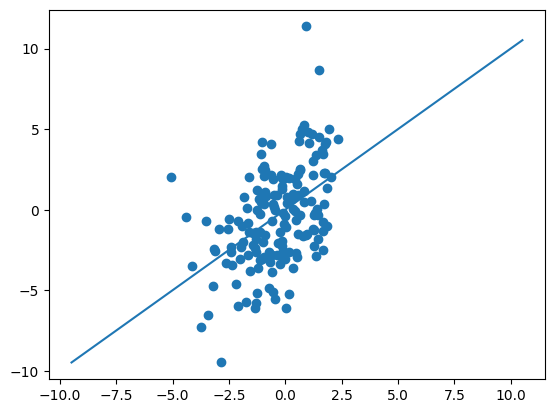

In [40]:
predictors = ['fpts_game-1', 'same_team','fpts_std', 'fpts_mean']

r_score, slope, intercept, lr = lr_predict(wr_true,predictors, 'fpts_diff', 30, True, True)

In [104]:
from scipy.stats import zscore
adj_std = wr['fpts_game_actual'].std()
wr['adj_std'] = wr['fpts_game_std'].replace(0,3)
wr['adj_std'] = (wr['adj_std'] + adj_std)/2




wr['range'] = wr['high'] - wr['low']

mean_std = wr[wr['fpts_game_std'] > 0]['fpts_game_std'].mean() 
wr['high'] = wr['fpts_game_mean'] + mean_std
wr['low'] = wr['fpts_game_mean'] - mean_std

print(len(wr[(wr['fpts_game_actual'] <= wr['high'])&(wr['fpts_game_actual'] >= wr['low'])])/len(wr))


0.38336713995943206


## Clustering

In [294]:
#repeat process from import to create dataframe with just the average values from previous years stored
data_columns = ['avg_depth_of_target', 'slot_rate', 'targeted_qb_rating', 'targets', 'touchdowns', 'wide_rate',
       'yards_after_catch_per_reception', 'yards_per_reception', 'yprr', 'fpts', 'fpts_game', 'targets_game', 'touchdowns_game']
years = [2018,2019,2020,2021,2022,2023,2024]

wr_data_names = pd.DataFrame(wr_data['player'].unique()).copy()
wr_data_names.columns = ['player']

wr_df_list = []
for year in years:
       if year == 2018: continue
       wr_data_split = wr_data_names.copy()
       for column in data_columns:
              df = wr_data[wr_data['year'] < year].groupby('player')[column].mean().reset_index()
              wr_data_split = pd.merge(wr_data_split, df, 'inner', 'player')
       wr_data_split['year'] = year
       wr_df_list.append(wr_data_split)

wr_cluster = pd.concat(wr_df_list)
wr_cluster = pd.concat(wr_df_list).reset_index(drop=True)
wr_cluster = pd.merge(wr_cluster, wr_data[['player', 'year', 'fpts_game']], 'left', ['player', 'year'])
wr_cluster.rename(columns={'fpts_game_x': 'fpts_game', 'fpts_game_y': 'fpts_game_actual'}, inplace=True)
wr_cluster = wr_cluster.dropna(subset=['fpts_game_actual']).reset_index(drop=True)

#find greatest correlation values - looking for top 3 most independent values
columns = ['avg_depth_of_target', 'slot_rate', 'targeted_qb_rating', 'targets', 'touchdowns', 'wide_rate',
       'yards_after_catch_per_reception', 'yards_per_reception', 'yprr', 'fpts', 'fpts_game', 'targets_game', 'touchdowns_game',
       'fpts_game_actual']
correlation = wr_cluster[columns].corr()
correlation['fpts_game_actual'].sort_values()
# fpts_game                          0.645353

#find the next highest that is the least correlated with fpts_game
correlation['factor2_compound'] = (1 - correlation['fpts_game']) * correlation['fpts_game_actual']
correlation[['fpts_game','fpts_game_actual','factor2_compound']].sort_values(by='factor2_compound', ascending=False)
#targeted_qb_rating	0.475072	0.363981	0.191064

#find third highest correlation
correlation['factor3_compound'] = (1 - correlation['fpts_game']) * (1 - correlation['targeted_qb_rating']) * correlation['fpts_game_actual']
correlation[['fpts_game','targeted_qb_rating','fpts_game_actual','factor3_compound']].sort_values(by='factor3_compound', ascending=False)
#decision between following two factors 
# wide_rate	0.133524	-0.055053	0.134925	0.123345
# yards_per_reception	0.205215	0.263598	0.190293	0.111375 #selected factor - much stronger correlation with fpts_game_actual


#add column for team change
wr_tumult = wr_cluster.copy()
wr_tumult = pd.merge(wr_tumult, wr_data[['player', 'year', 'team_name']], 'left', left_on=['player', 'year'], right_on=['player', 'year'])
wr_tumult['last_year'] = wr_tumult['year'] - 1
wr_tumult = pd.merge(wr_tumult, wr_data[['player', 'year', 'team_name']], 'left', left_on=['player', 'last_year'], right_on=['player', 'year'])
wr_tumult.rename(columns={'year_x': 'year', 'team_name_x': 'team_name', 'team_name_y': 'last_team'}, inplace=True)
wr_tumult.drop('year_y', inplace=True, axis=1)
wr_tumult['same_team'] = (wr_tumult['team_name'] == wr_tumult['last_team']).astype(int)

wr_cluster = wr_tumult.copy()
wr_cluster

,player,avg_depth_of_target,slot_rate,targeted_qb_rating,targets,touchdowns,wide_rate,yards_after_catch_per_reception,yards_per_reception,yprr,fpts,fpts_game,targets_game,touchdowns_game,year,fpts_game_actual,team_name,last_year,last_team,same_team
0,DeAndre Hopkins,12.2,19.7,115.2,169.0,11.0,80.3,3.3,13.4,2.35,286.9,16.876471,9.941176,0.647059,2019,14.047059,HST,2018,HST,1
1,Michael Thomas,8.3,32.0,124.0,168.0,10.0,67.9,4.1,11.4,2.64,291.7,16.205556,9.333333,0.555556,2019,18.323529,NO,2018,NO,1
2,Julio Jones,14.3,20.8,109.4,166.0,8.0,79.2,4.0,14.8,2.93,272.2,17.012500,10.375000,0.500000,2019,14.993333,ATL,2018,ATL,1
3,Davante Adams,11.7,20.7,121.6,162.0,13.0,79.1,4.3,12.5,2.12,272.1,18.140000,10.800000,0.866667,2019,15.821429,GB,2018,GB,1
4,JuJu Smith-Schuster,9.3,61.0,100.6,161.0,7.0,39.0,5.9,12.8,2.08,240.1,15.006250,10.062500,0.437500,2019,7.850000,PIT,2018,PIT,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,Khalil Shakir,7.4,76.8,141.5,56.0,4.0,22.3,7.0,14.0,1.75,117.1,6.163158,2.947368,0.210526,2024,10.333333,BUF,2023,BUF,1
489,Jameson Williams,16.4,35.4,89.7,51.0,3.0,64.6,3.5,14.4,1.30,76.3,5.086667,3.400000,0.200000,2024,10.409091,DET,2023,DET,1
490,Cedric Tillman,12.2,38.5,26.4,42.0,0.0,58.6,3.2,10.7,0.63,32.9,2.350000,3.000000,0.000000,2024,6.036364,CLV,2023,CLV,1
491,Jalen Tolbert,14.2,36.1,91.0,36.0,2.0,63.9,1.4,12.2,0.89,49.8,2.766667,2.000000,0.111111,2024,6.815385,DAL,2023,DAL,1


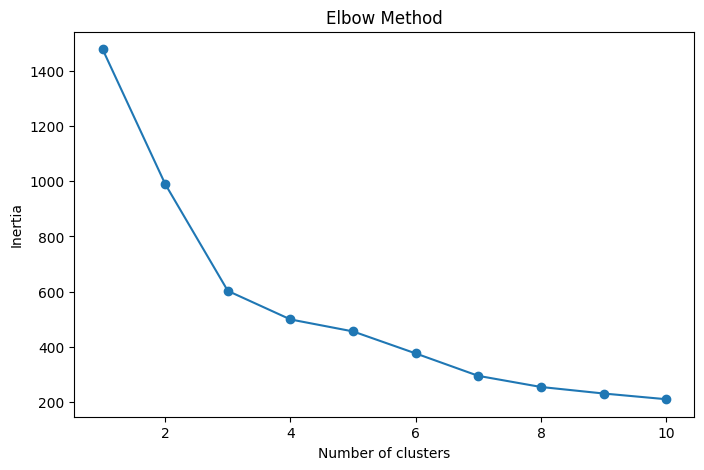

In [301]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

factors = ['fpts_game','targeted_qb_rating','same_team']
wr_cluster_factors = wr_cluster[factors]

scaler = StandardScaler()
wr_cluster_scaled = scaler.fit_transform(wr_cluster_factors)

# Determine optimal number of clusters (K) using the Elbow Method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(wr_cluster_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow method to decide on the best 'K'
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# choose 4 clusters (7 is also viable choice)
# planning to do regression on values after so keeping more samples in each set is valuable)

# # Apply K-means with K=4
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(wr_cluster_scaled)

# Add the cluster identifiers as a new attribute in the original data
wr_cluster_scaled = pd.DataFrame(wr_cluster_scaled)
wr_cluster_scaled['cluster'] = kmeans.labels_
wr_cluster['cluster'] = kmeans.labels_

wr_cluster_scaled.columns = ['fpts_game','targeted_qb_rating','yards_per_reception','cluster']

# asses created clusters
wr_cluster['fpts_game_diff'] = wr_cluster['fpts_game'] - wr_cluster['fpts_game_actual']
factors = ['fpts_game','targeted_qb_rating','yards_per_reception','fpts_game_actual','cluster']
wr_cluster[factors].groupby('cluster').size()
#appropriate size of clusters (57-166)
clusters_mean = wr_cluster[factors].groupby('cluster').mean()
wr_cluster[['fpts_game','targeted_qb_rating','yards_per_reception','fpts_game_actual','cluster','fpts_game_diff']].groupby('cluster').mean()
# method seems to have identified one cluster that has the greatest difference in fantasy points average and actual
# approximate [1.3, 0.04, -0.03, -0.19]
clusters_std = wr_cluster[factors].groupby('cluster').std()
# all ranges clusters whos fpts_game_actual std is about 2.9/3.4 - compared to 3.79 for dataset overall
# this shows that some kind of meaningful clustering has occured

In [302]:
#if I set each member of a cluster to have a normal dist with parameters based on group, how many will fall inside?
wr_cluster_norm = pd.merge(wr_cluster, clusters_mean['fpts_game'], 'left', on='cluster')
wr_cluster_norm = pd.merge(wr_cluster_norm, clusters_std['fpts_game'], 'left', on='cluster')
wr_cluster_norm.rename(columns={'fpts_game_x': 'fpts_game', 'fpts_game_y': 'fpts_game_mean', 'fpts_game': 'fpts_game_std'}, inplace=True)
wr_cluster_norm['high'] = wr_cluster_norm['fpts_game_mean'] + wr_cluster_norm['fpts_game_std']
wr_cluster_norm['low'] = wr_cluster_norm['fpts_game_mean'] - wr_cluster_norm['fpts_game_std']
wr_cluster_norm['in'] = (wr_cluster_norm['fpts_game_actual'] <= wr_cluster_norm['high']) & (wr_cluster_norm['fpts_game_actual'] >= wr_cluster_norm['low'])
wr_cluster_norm['in'].sum()/len(wr_cluster_norm)
#47% is already pretty good, close to viable distribution

0.4685598377281947

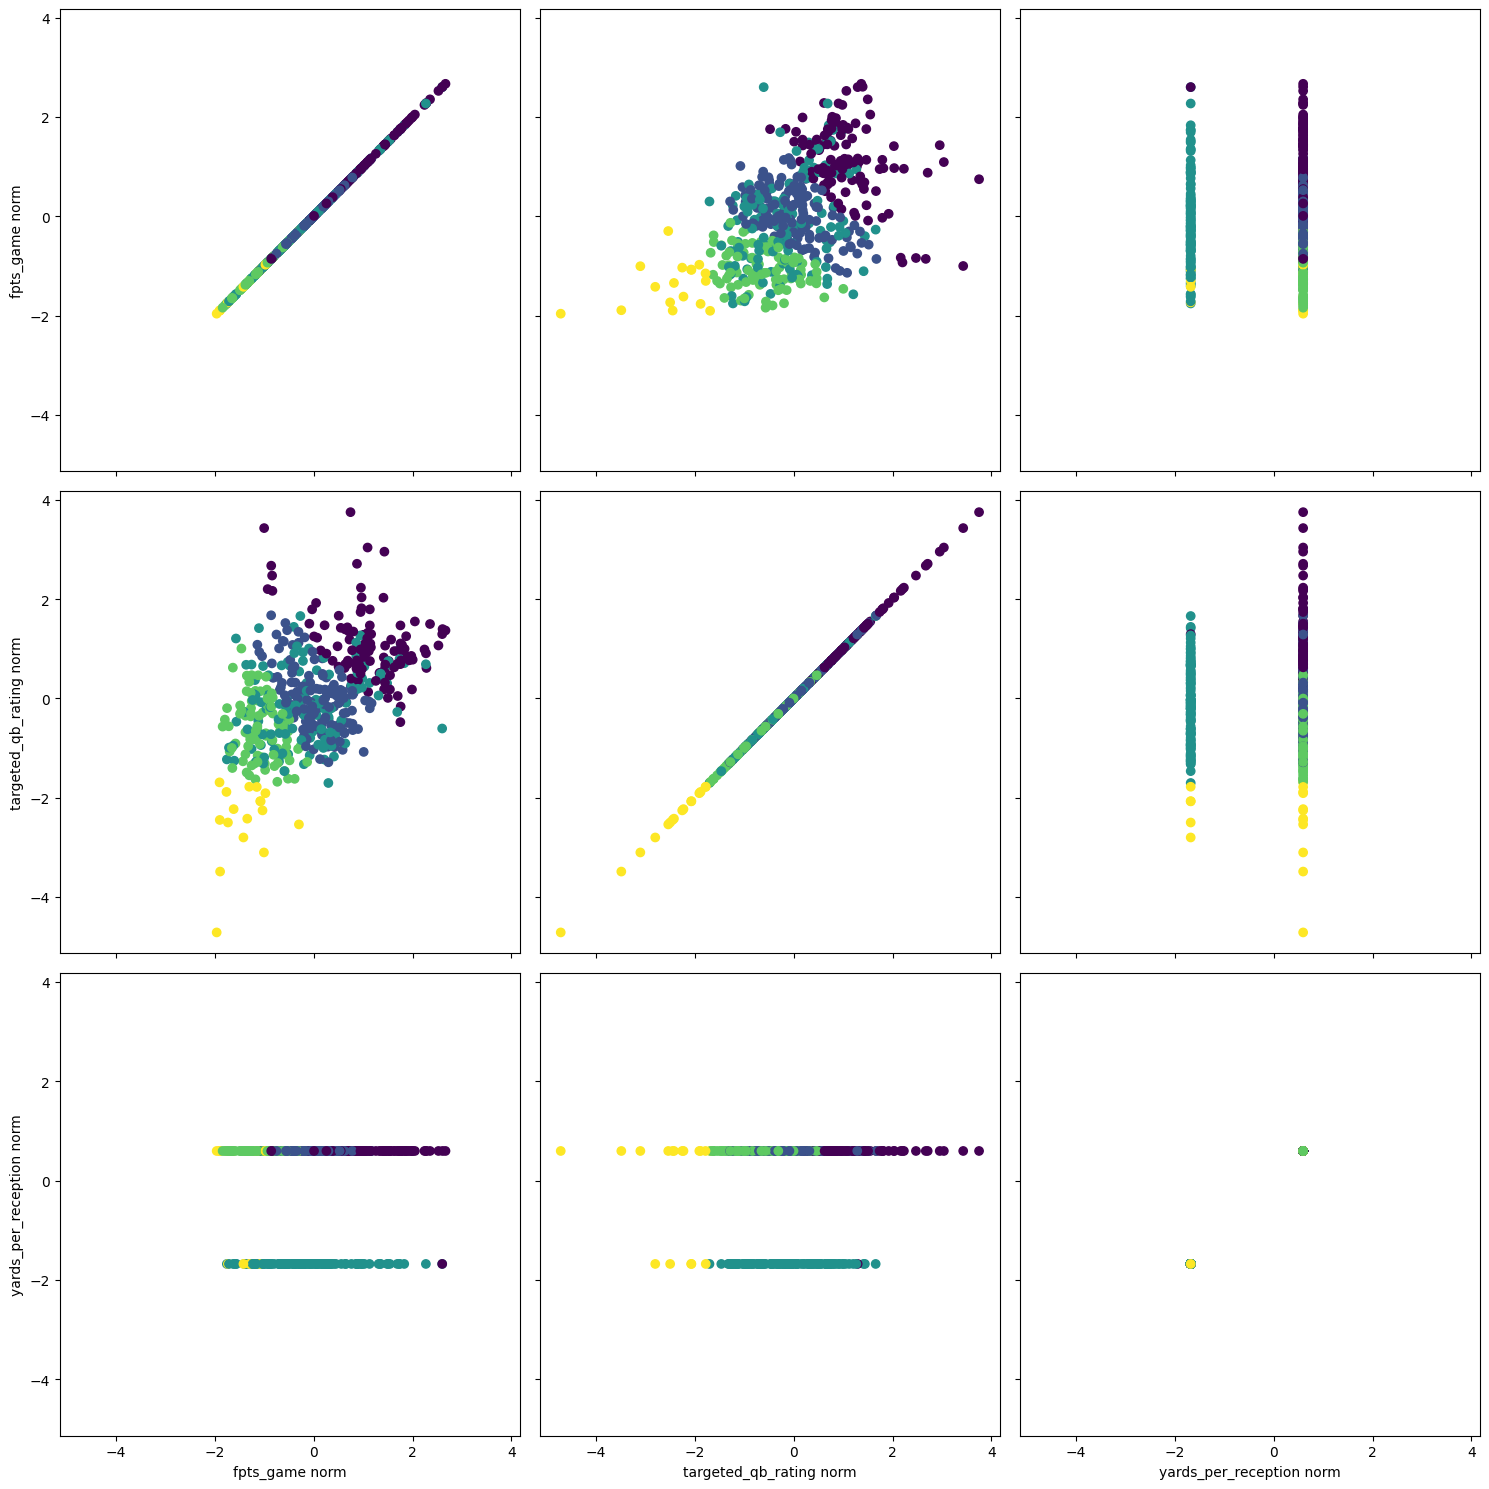

In [303]:
#plot the clusters
fig, axs = plt.subplots(3,3, figsize=(15,15), sharex=True, sharey=True)
for i, factor1 in enumerate(['fpts_game','targeted_qb_rating','yards_per_reception']):
    for j, factor2 in enumerate(['fpts_game','targeted_qb_rating','yards_per_reception']):
        axs[i,j].scatter(wr_cluster_scaled[factor2], wr_cluster_scaled[factor1], c=wr_cluster_scaled['cluster'])
        title2 = factor2 + ' norm'
        title1 = factor1 + ' norm'
        if i == 2: axs[i,j].set_xlabel(title2)
        if j == 0: axs[i,j].set_ylabel(title1)

plt.tight_layout()
plt.show()

### Linear regression based on clusters

In [306]:
#find regression for each cluster
columns = ['avg_depth_of_target', 'slot_rate', 'targeted_qb_rating', 'targets', 'touchdowns', 'wide_rate',
       'yards_after_catch_per_reception', 'yards_per_reception', 'yprr', 'fpts', 'fpts_game', 'targets_game', 'touchdowns_game',
       'fpts_game_actual']

for cluster in range(wr_cluster['cluster'].max() + 1):

       #find the 3 biggest correlation factors for each cluster and use as regression inputs
       correlation = wr_cluster[wr_cluster['cluster'] == cluster][columns].corr()
       factor1 = correlation[correlation.index != 'fpts_game_actual'].sort_values(by='fpts_game_actual', ascending=False).index[0]

       correlation['factor2_compound'] = (1 - correlation[factor1]) * correlation['fpts_game_actual']
       factor2 = correlation[(correlation.index != 'fpts_game_actual') & (correlation.index != factor1)].sort_values(by='factor2_compound', ascending=False).index[0]

       correlation['factor3_compound'] = (1 - correlation[factor1]) * (1 - correlation[factor2]) * correlation['fpts_game_actual']
       factor3 = correlation[(correlation.index != 'fpts_game_actual') & (correlation.index != factor1) & (correlation.index != factor2)].sort_values(by='factor3_compound', ascending=False).index[0]

       factors = [factor1, factor2, factor3]
       # print(factors)

       #perform linear regression
       r_score, slope, intercept, lr = lr_predict(wr_cluster[wr_cluster['cluster'] == cluster],factors, 'fpts_game_actual', 30, False, False)
       mean = wr_cluster[wr_cluster['cluster'] == cluster]['fpts_game'].mean()
       std = wr_cluster[wr_cluster['cluster'] == cluster]['fpts_game'].std()


       # linear regression worked well for 2 clusters >0.4 R
       # it was useless for others <0.2 R
       # however the ones that it was bad for the clusters were very tight and could be predicted with a single value
       if r_score > 0.15:
              wr_cluster.loc[wr_cluster['cluster'] == cluster, 'predicted'] = lr.predict(wr_cluster[wr_cluster['cluster'] == cluster][factors])
              wr_cluster.loc[wr_cluster['cluster'] == cluster, 'std'] = std
       else:
              wr_cluster.loc[wr_cluster['cluster'] == cluster, 'predicted'] = mean
              wr_cluster.loc[wr_cluster['cluster'] == cluster, 'std'] = wr_cluster['fpts_game'].std()




#find percent of each cluster that fits within set standard deviations
lr_predict(wr_cluster,['predicted'], 'fpts_game_actual', 30, False, True)
wr_cluster['high'] = wr_cluster['predicted'] + wr_cluster['std']
wr_cluster['low'] = wr_cluster['predicted'] - wr_cluster['std']
wr_cluster['in'] = ((wr_cluster['fpts_game_actual'] <= wr_cluster['high']) & (wr_cluster['fpts_game_actual'] >= wr_cluster['low'])).astype(int)

print(wr_cluster['in'].sum()/len(wr_cluster))

wr_cluster.groupby('cluster')['in'].sum()/wr_cluster.groupby('cluster')['in'].size()


R score  0.4012381528437431
Slope [1.03998715]
Intercept -0.771277518159124
0.5517241379310345


cluster
0    0.693694
1    0.453947
2    0.609756
3    0.411111
4    0.823529
Name: in, dtype: float64

### Visualize predictions for 2024

                  player  fpts_game_actual  predicted
455       Rashod Bateman          8.069231   4.361230
490       Cedric Tillman          6.036364   4.361230
454  Ray-Ray McCloud III          6.915385   4.361230
448        Van Jefferson          3.392308   4.361230
482      Demario Douglas          6.284615   4.361230
..                   ...               ...        ...
417           Mike Evans         12.250000  13.438528
474           Puka Nacua         14.475000  13.539978
449        Ja'Marr Chase         19.630769  13.841298
440     Justin Jefferson         15.115385  14.185710
414          Tyreek Hill         10.723077  14.971438

[82 rows x 3 columns]


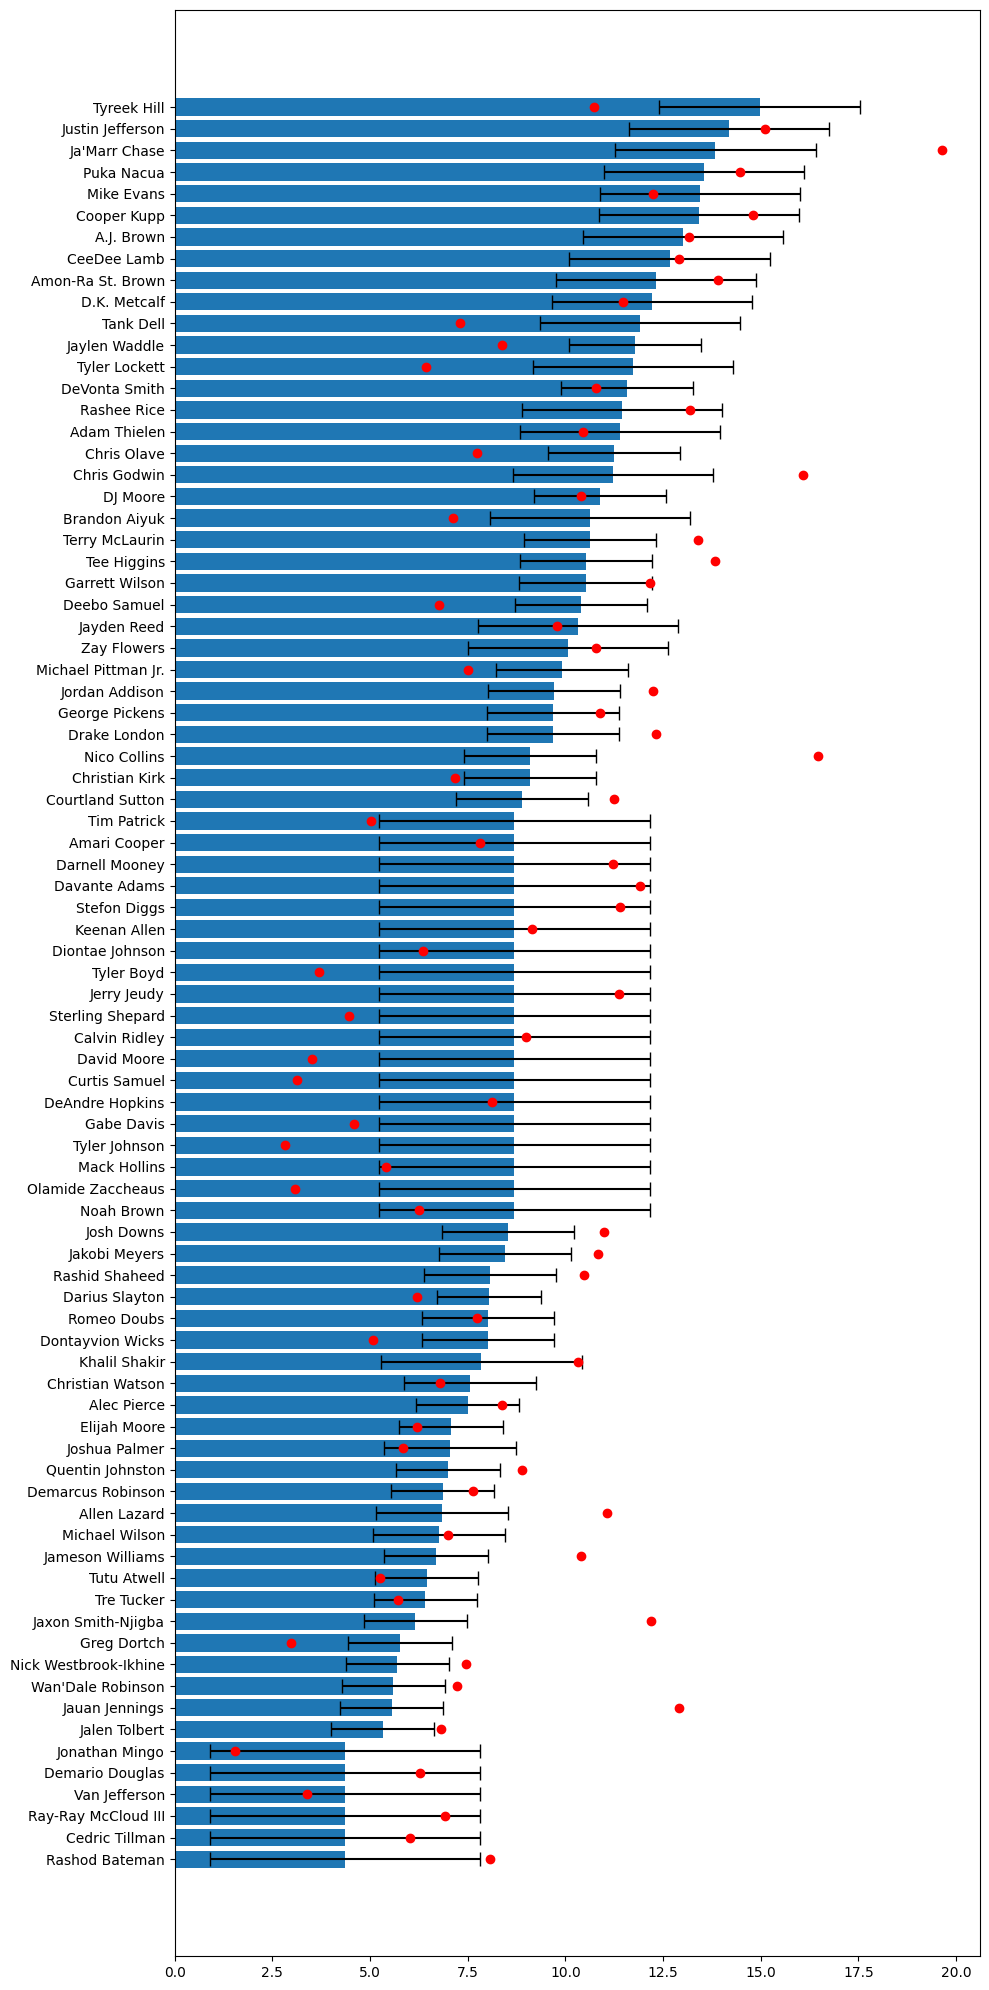

In [ ]:
wr_2024 = wr_cluster[wr_cluster['year'] == 2024].sort_values(by='predicted',ascending=True)

plt.figure(figsize=(10,20))
plt.barh(wr_2024['player'], wr_2024['predicted'], xerr=wr_2024['std'],capsize=5)
plt.plot(wr_2024['fpts_game_actual'], wr_2024['player'], 'o', color='red')
plt.tight_layout()



In [311]:
print(wr_2024[['player','fpts_game_actual','predicted']].to_string())

                    player  fpts_game_actual  predicted
455         Rashod Bateman          8.069231   4.361230
490         Cedric Tillman          6.036364   4.361230
454    Ray-Ray McCloud III          6.915385   4.361230
448          Van Jefferson          3.392308   4.361230
482        Demario Douglas          6.284615   4.361230
481         Jonathan Mingo          1.546154   4.361230
491          Jalen Tolbert          6.815385   5.325811
460         Jauan Jennings         12.900000   5.555305
483      Wan'Dale Robinson          7.230769   5.602118
458  Nick Westbrook-Ikhine          7.453846   5.702523
470            Greg Dortch          2.984615   5.770849
480     Jaxon Smith-Njigba         12.200000   6.158138
492             Tre Tucker          5.707692   6.418662
472            Tutu Atwell          5.246154   6.449915
489       Jameson Williams         10.409091   6.687129
487         Michael Wilson          6.984615   6.760138
438           Allen Lazard         11.062500   6